In [1]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


#*******************************************************
# DATA IMPORT

data = pd.read_csv('../data/selftext_preprocessed.csv')

#*******************************************************
# FUNCTIONS

# function to output results report
def print_results(grid, X_train, X_test, y_train, y_test):   
    # ***** Display Results *****  
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(classification_report(y_test, grid.predict(X_test)))
    print('\n')
    print(f'Best Params : {grid.best_params_}')
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(grid.best_estimator_, X_test, y_test, display_labels=['Thetruthishere', 'Supernatural'], normalize='true', ax=ax);

    
# functions to output top predictive words for each subreddit category
def top_words(X, vect):
    coefs = grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]].coef_
    coef_df = pd.DataFrame({'coefs':coefs[0]}, index = grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[0]].get_feature_names())
    most_important_25 = coef_df.nlargest(25, 'coefs')
    least_important_25 = coef_df.nsmallest(25, 'coefs')
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
    most_important_25.plot.barh(ax = ax1)
    least_important_25.plot.barh(ax = ax2)
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax2.yaxis.tick_right()
    ax2.set_xticklabels(np.absolute(ax2.get_xticks()))
    ax1.set_xlabel('Coefficient Relevance',fontsize = 16)
    ax2.set_xlabel('Coefficient Relevance',fontsize = 16)
    ax1.set_title('Thetruthishere', fontsize = 20)
    ax2.set_title('Supernatural', fontsize = 20)
    fig.suptitle('Top 25 Predictive Words', fontsize = 24)

In [3]:
X = data['selftext']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)

<br><br>

---

# Index:
* ### [Section 1](#Section-1)
    - #### Models using:
        - CountVectorizer / TfidfVectorizer
        - StandardScaler / No-Scaling
        - LogisticRegression / MultinomialNB
<br><br>     
* ### [Section 2](#Section-2)
    - #### Models using:
        - CountVectorizer / TfidfVectorizer
        - DecisionTreeClassifier / BaggingClassifier / RandomForestClassifier
<br><br>


---

<br><br>

# Section 1

### 8 models configured as permutations of the following pipeline steps:

| Vectorizer | Scaler | Classifier |
| ----------- | ----------- | ----------- |
| CountVectorizer | No Scaling | LogisticRegression |
| TfidfVectorizer | StandardScaler | MultinomialNaiveBayes|

#### Results:
* Applying a StandardScaler to the pipeline is not explicitly necessary and not only does not improve predictive performance, but instead can be seen to reduce scores by ~1% when compared to non-scaled models.
* Accuracy scores of the included models fall between 95-92%.

---

<br><br>

### MODEL: CountVectorizer / Logistic Regression

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [100, 500, 1000]<br>'countvectorizer__ngram_range': [(1, 2)]
| Scaler | None | |
| Classifier | LogisticRegression | 'logisticregression__C': [.1, 1, 10] |

*** TEST set ***
Score : 0.9510553686142551
                precision    recall  f1-score   support

  Supernatural       0.95      0.91      0.93      1117
Thetruthishere       0.95      0.97      0.96      2152

      accuracy                           0.95      3269
     macro avg       0.95      0.94      0.95      3269
  weighted avg       0.95      0.95      0.95      3269



Best Params : {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 1}


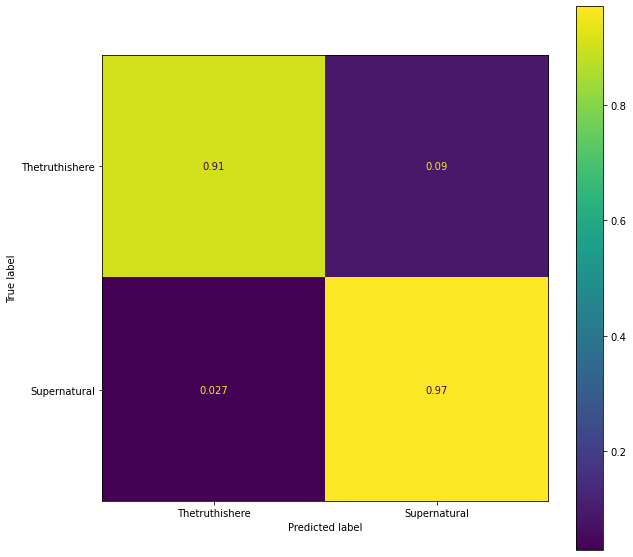

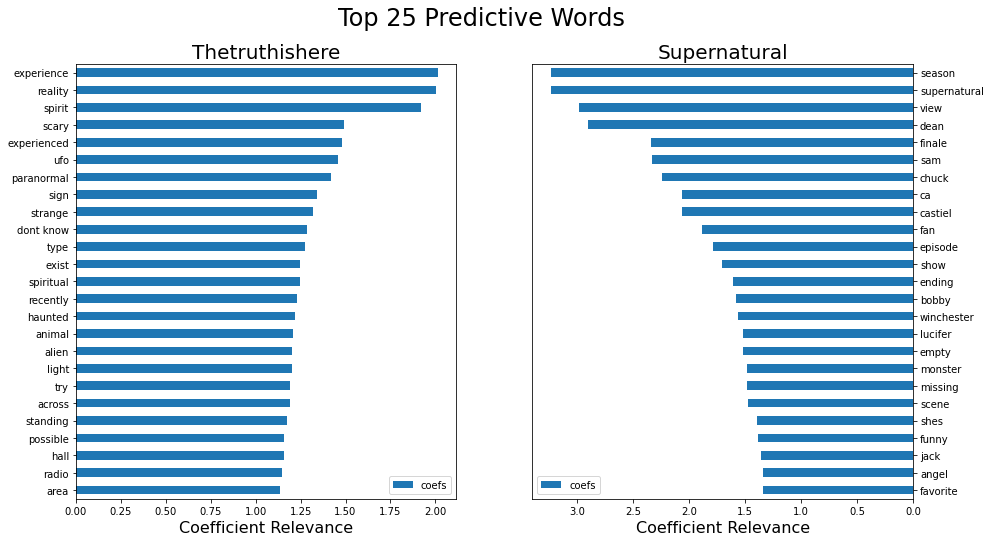

In [10]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('logisticregression', LogisticRegression(max_iter=10_000))])
param = [
    {
        'logisticregression__C': [.1, 1, 10],
        'countvectorizer__max_features': [100, 500, 1000],
        'countvectorizer__ngram_range': [(1, 2)]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

### MODEL: CountVectorizer / StandardScaler / Logistic Regression

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [100, 500, 1000]<br>'countvectorizer__ngram_range': [(1, 2)]
| Scaler | StandardScaler | with_mean=False |
| Classifier | LogisticRegression | 'logisticregression__C': [.1, 1, 10] |

*** TEST set ***
Score : 0.9525848883450596
                precision    recall  f1-score   support

  Supernatural       0.94      0.92      0.93      1117
Thetruthishere       0.96      0.97      0.96      2152

      accuracy                           0.95      3269
     macro avg       0.95      0.94      0.95      3269
  weighted avg       0.95      0.95      0.95      3269



Best Params : {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 0.1}


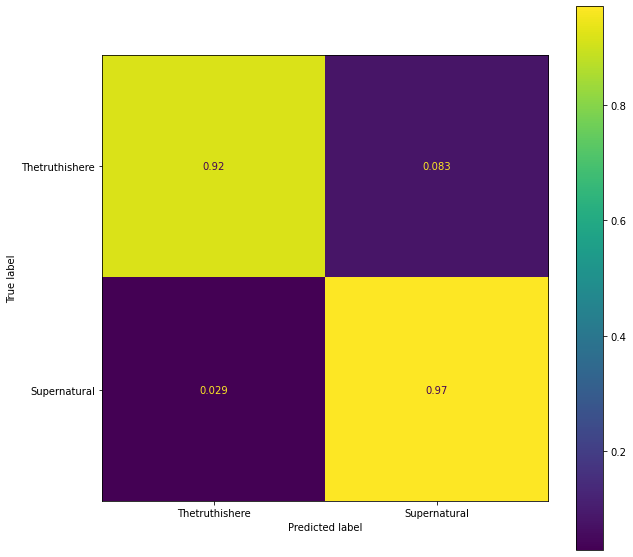

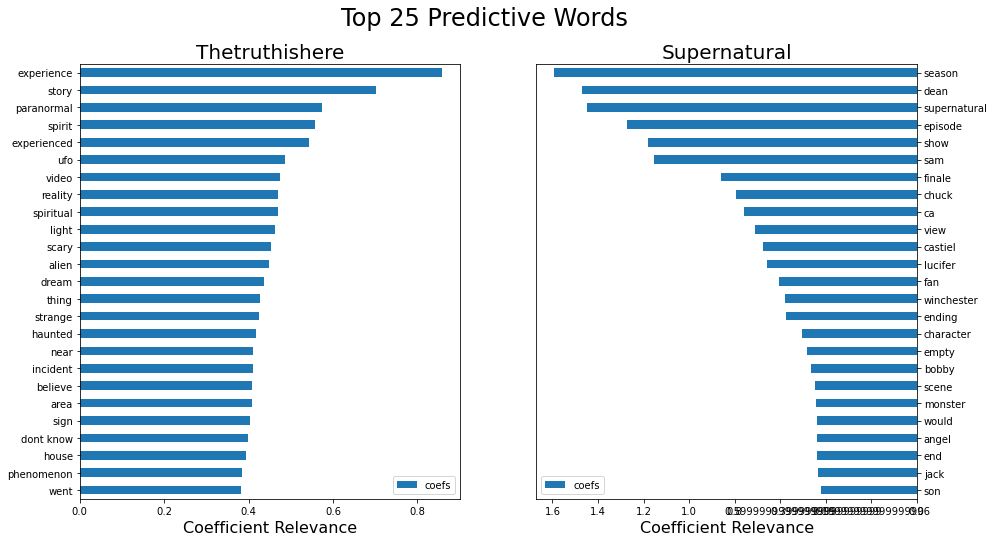

In [23]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('standardscaler', StandardScaler(with_mean=False)), ('logisticregression', LogisticRegression(max_iter=10_000))])
param = [
    {
        'logisticregression__C': [.1, 1, 10],
        'countvectorizer__max_features': [100, 500, 1000],
        'countvectorizer__ngram_range': [(1, 2)]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

---

---

<br><br>

### MODEL: TfidfVectorizer / Logistic Regression

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | TfidfVectorizer | 'tfidfvectorizer__max_features': [500, 1000]<br>'tfidfvectorizer__ngram_range': [(1, 2)]
| Scaler | None | |
| Classifier | LogisticRegression | 'logisticregression__C': [.1, 1, 10] |

*** TEST set ***
Score : 0.9568675435913123
                precision    recall  f1-score   support

  Supernatural       0.96      0.91      0.94      1117
Thetruthishere       0.96      0.98      0.97      2152

      accuracy                           0.96      3269
     macro avg       0.96      0.95      0.95      3269
  weighted avg       0.96      0.96      0.96      3269



Best Params : {'logisticregression__C': 10, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2)}


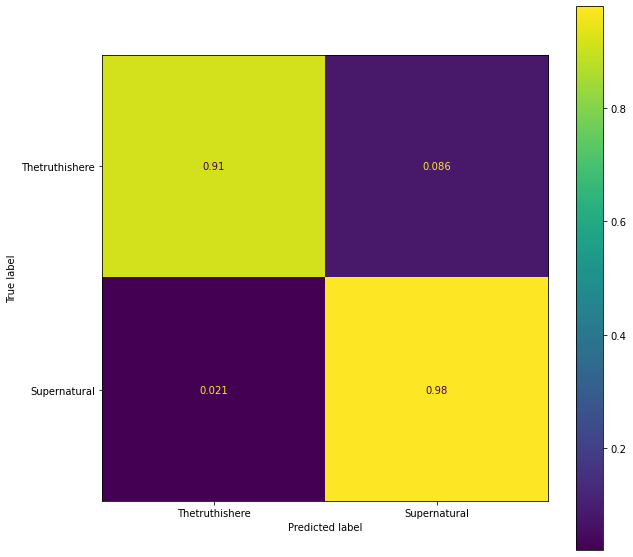

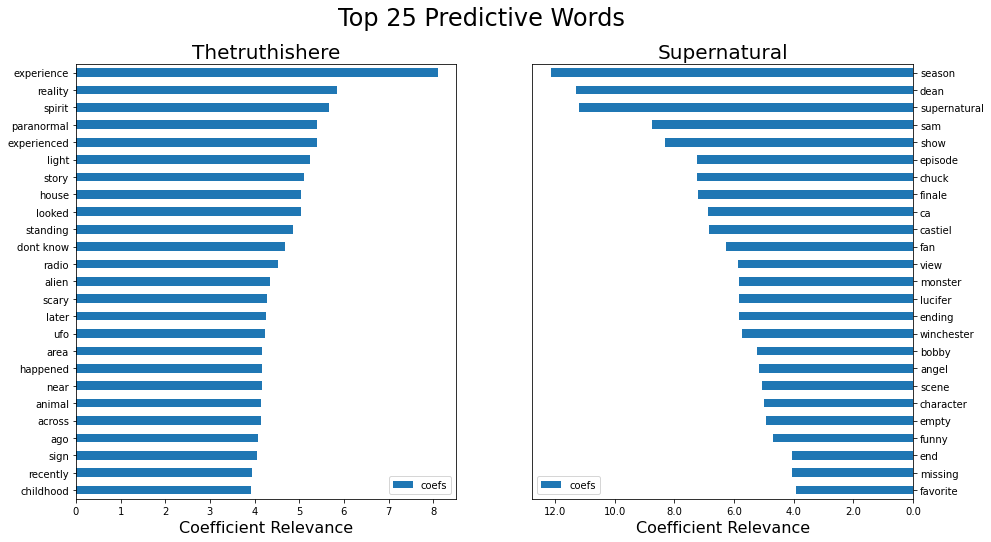

In [14]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('logisticregression', LogisticRegression(max_iter=10_000))])
param = [
    {
        'logisticregression__C': [.1, 1, 10],
        'tfidfvectorizer__max_features': [500, 1000],
        'tfidfvectorizer__ngram_range': [(1, 2)]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

### MODEL: TfidfVectorizer / StandardScaler / Logistic Regression

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | TfidfVectorizer | 'tfidfvectorizer__max_features': [500, 1000]<br>'tfidfvectorizer__ngram_range': [(1, 2)]
| Scaler | StandardScaler | with_mean=False |
| Classifier | LogisticRegression | 'logisticregression__C': [.1, 1, 10] |

*** TEST set ***
Score : 0.9440195778525543
                precision    recall  f1-score   support

  Supernatural       0.93      0.90      0.92      1117
Thetruthishere       0.95      0.96      0.96      2152

      accuracy                           0.94      3269
     macro avg       0.94      0.93      0.94      3269
  weighted avg       0.94      0.94      0.94      3269



Best Params : {'logisticregression__C': 0.1, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2)}


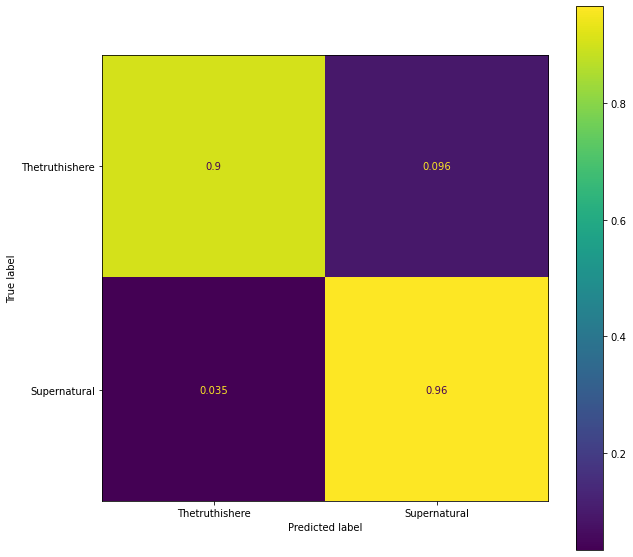

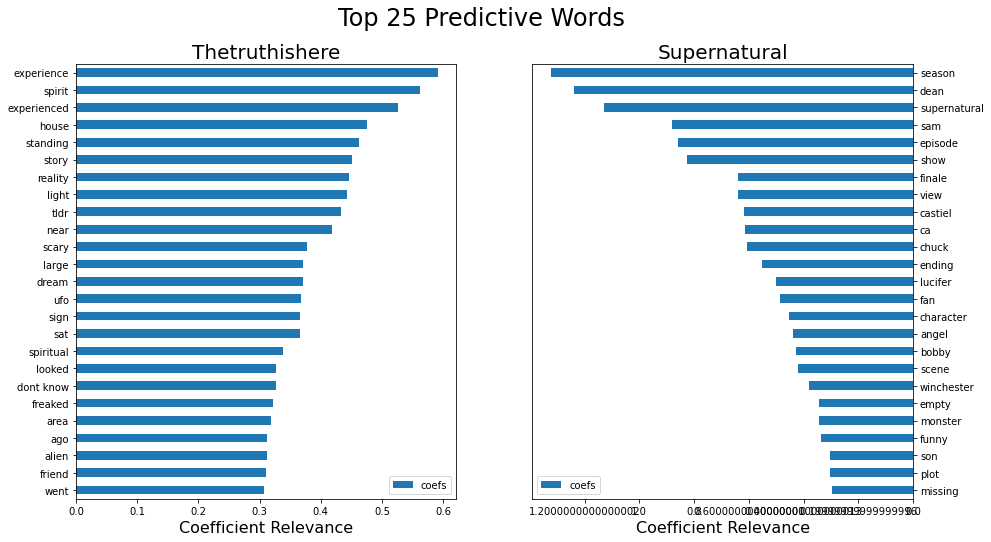

In [15]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('standardscaler', StandardScaler(with_mean=False)), ('logisticregression', LogisticRegression(max_iter=10_000))])
param = [
    {
        'logisticregression__C': [.1, 1, 10],
        'tfidfvectorizer__max_features': [500, 1000],
        'tfidfvectorizer__ngram_range': [(1, 2)]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

---

---

<br><br>

### MODEL: CountVectorizer / MultinomialNB

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [500, 1000]
| Scaler | None | |
| Classifier | MultinomialNB | 'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100] |

*** TEST set ***
Score : 0.9394310186601407
                precision    recall  f1-score   support

  Supernatural       0.91      0.92      0.91      1117
Thetruthishere       0.96      0.95      0.95      2152

      accuracy                           0.94      3269
     macro avg       0.93      0.93      0.93      3269
  weighted avg       0.94      0.94      0.94      3269



Best Params : {'countvectorizer__max_features': 1000, 'multinomialnb__alpha': 0.01}


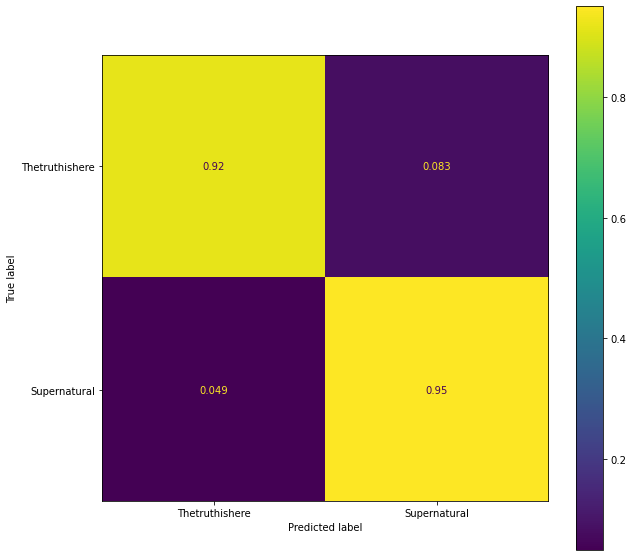

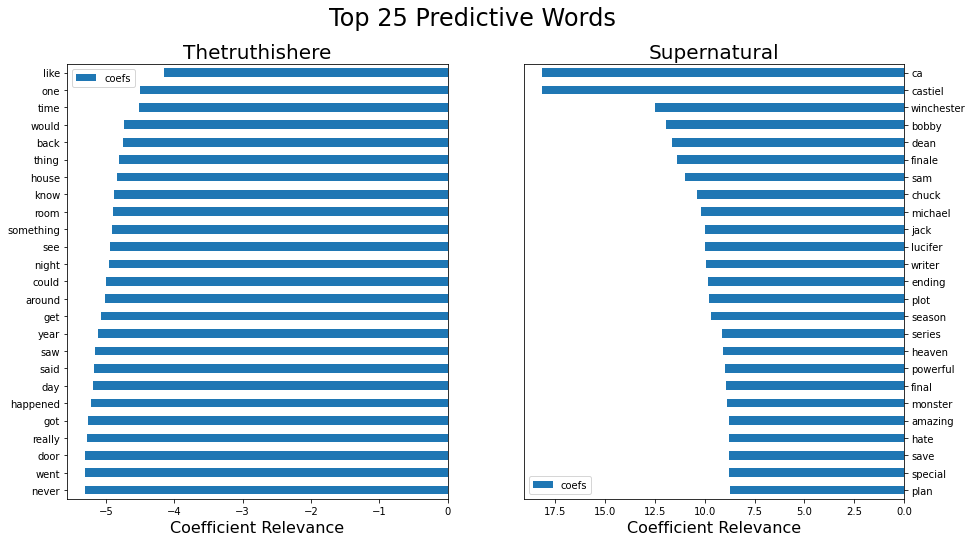

In [19]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('multinomialnb', MultinomialNB(fit_prior=True))])
param = [
    {
        'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100],
        'countvectorizer__max_features': [500, 1000],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

### MODEL: CountVectorizer / StandardScaler / MultinomialNB

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [500, 1000]
| Scaler | StandardScaler | with_mean=False |
| Classifier | MultinomialNB | 'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100] |

*** TEST set ***
Score : 0.9284184765983481
                precision    recall  f1-score   support

  Supernatural       0.88      0.92      0.90      1117
Thetruthishere       0.96      0.93      0.94      2152

      accuracy                           0.93      3269
     macro avg       0.92      0.93      0.92      3269
  weighted avg       0.93      0.93      0.93      3269



Best Params : {'countvectorizer__max_features': 1000, 'multinomialnb__alpha': 0.01}


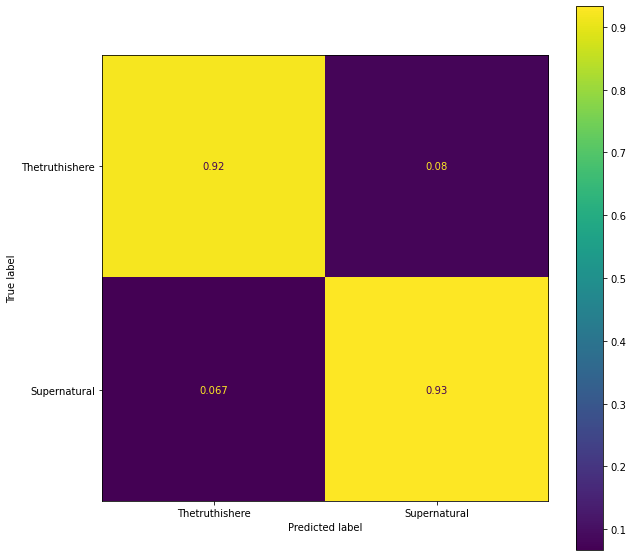

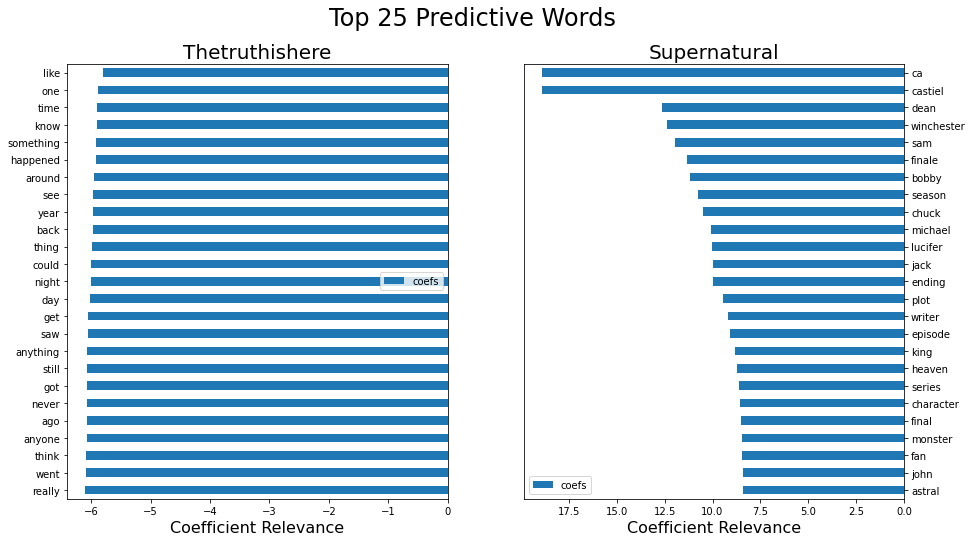

In [20]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('standardscaler', StandardScaler(with_mean=False)), ('multinomialnb', MultinomialNB(fit_prior=True))])
param = [
    {
        'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100],
        'countvectorizer__max_features': [500, 1000],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

---

---

<br><br>

### MODEL: TfidfVectorizer / MultinomialNB

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | TfidfVectorizer | 'tfidfvectorizer__max_features': [500, 1000]
| Scaler | None | |
| Classifier | MultinomialNB | 'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100] |

*** TEST set ***
Score : 0.9492199449372897
                precision    recall  f1-score   support

  Supernatural       0.96      0.89      0.92      1117
Thetruthishere       0.95      0.98      0.96      2152

      accuracy                           0.95      3269
     macro avg       0.95      0.94      0.94      3269
  weighted avg       0.95      0.95      0.95      3269



Best Params : {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_features': 1000}


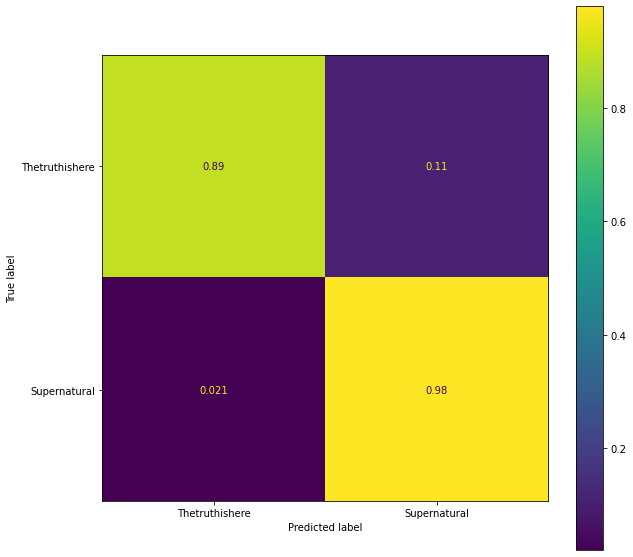

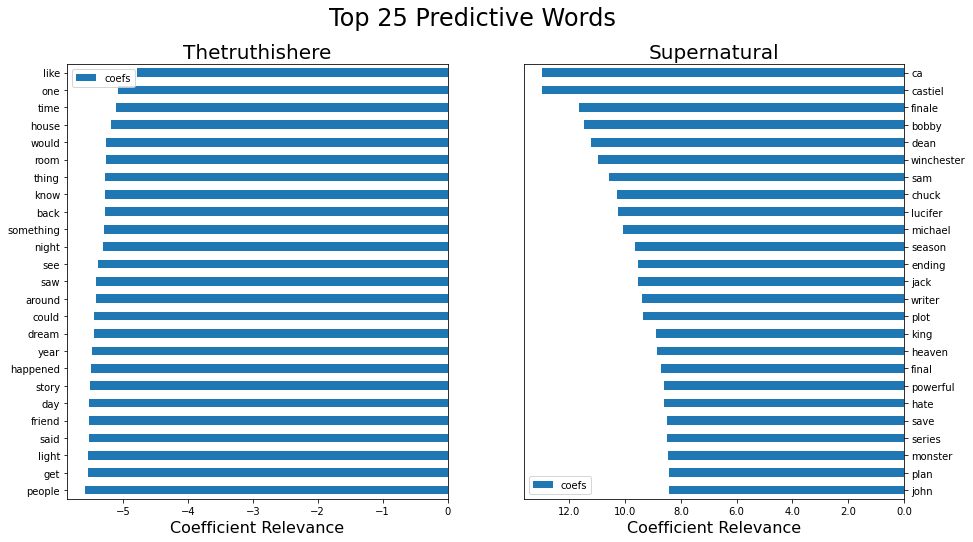

In [22]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB(fit_prior=True))])
param = [
    {
        'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100],
        'tfidfvectorizer__max_features': [500, 1000],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>

### MODEL: TfidfVectorizer / StandardScaler / MultinomialNB

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | TfidfVectorizer | 'tfidfvectorizer__max_features': [500, 1000]
| Scaler | StandardScaler | with_mean=False |
| Classifier | MultinomialNB | 'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100] |

*** TEST set ***
Score : 0.9284184765983481
                precision    recall  f1-score   support

  Supernatural       0.88      0.92      0.90      1117
Thetruthishere       0.96      0.93      0.94      2152

      accuracy                           0.93      3269
     macro avg       0.92      0.93      0.92      3269
  weighted avg       0.93      0.93      0.93      3269



Best Params : {'countvectorizer__max_features': 1000, 'multinomialnb__alpha': 0.01}


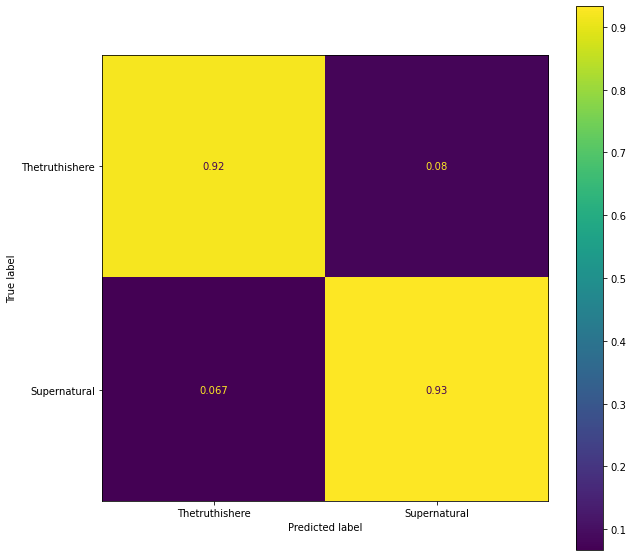

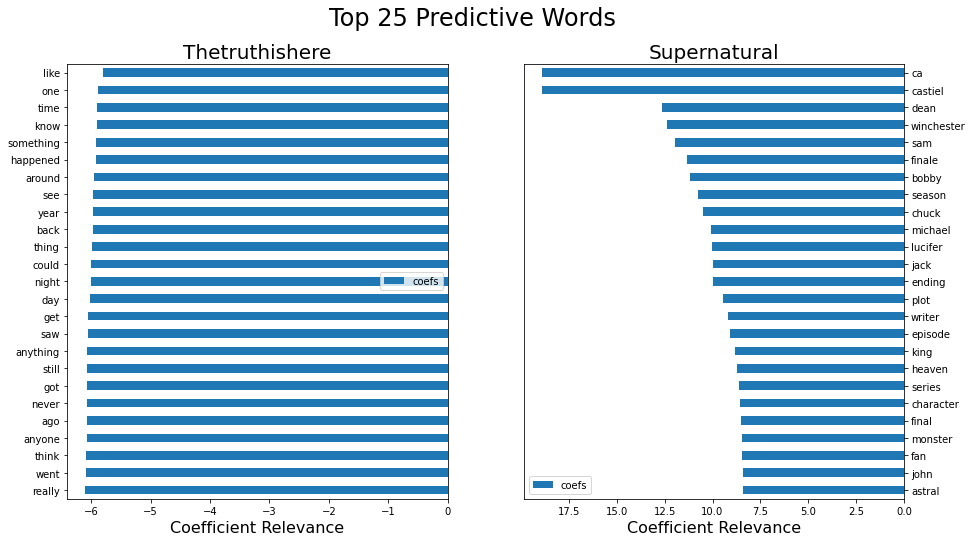

In [20]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('standardscaler', StandardScaler(with_mean=False)), ('multinomialnb', MultinomialNB(fit_prior=True))])
param = [
    {
        'multinomialnb__alpha' : [0.01, 0.1, 1, 10, 100],
        'tfidfvectorizer__max_features': [500, 1000],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br><br><br><br>

# Section 2

### 6 models configured as permutations of the following pipeline steps:

| Vectorizer | Classifier |
| ----------- | ----------- |
| CountVectorizer | DecisionTreesClassifier |
| TfidfVectorizer | BaggingClassifier|
| | RandomForestClassifier |

#### Results:
* Applying a StandardScaler to the pipeline is not explicitly necessary and not only does not improve predictive performance, but instead can be seen to reduce scores by ~1% when compared to non-scaled models.
* Accuracy scores of the included models fall between 95-92%.

---

<br><br>

### MODEL: CountVectorizer / DecisionTreeClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [100, 500, 1000]<br>'countvectorizer__ngram_range': [(1, 2)]
| Classifier | DecisionTreeClassifier | 'dtree__max_depth':[3,5,7]<br>'dtree__min_samples_leaf':[3,5,7]<br>'dtree__ccp_alpha':[0.1, 1, 10] |

*** TEST set ***
Score : 0.7714897522178036
                precision    recall  f1-score   support

  Supernatural       1.00      0.33      0.50      1117
Thetruthishere       0.74      1.00      0.85      2152

      accuracy                           0.77      3269
     macro avg       0.87      0.67      0.68      3269
  weighted avg       0.83      0.77      0.73      3269



Best Params : {'countvectorizer__max_features': 500, 'countvectorizer__ngram_range': (1, 2), 'dtree__ccp_alpha': 0.1, 'dtree__max_depth': 3, 'dtree__min_samples_leaf': 3}


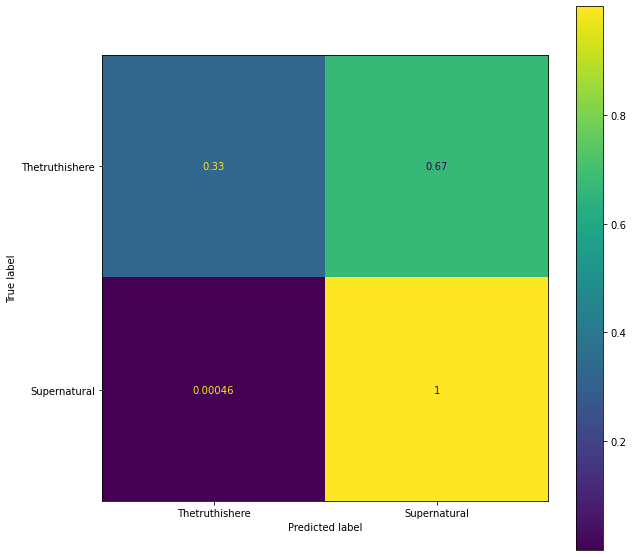

In [28]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('dtree', DecisionTreeClassifier())])
param = [
    {
        'countvectorizer__max_features': [500, 1000],
        'countvectorizer__ngram_range': [(1, 2)],
        'dtree__max_depth':[3,5,7],
        'dtree__min_samples_leaf':[3,5,7], 
        'dtree__ccp_alpha':[.1, 1, 10]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### MODEL: TfidfVectorizer / DecisionTreeClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'tfidfvectorizer__max_features': [100, 500, 1000]<br>'tfidfvectorizer__ngram_range': [(1, 2)]
| Classifier | DecisionTreeClassifier | 'dtree__max_depth':[3,5,7]<br>'dtree__min_samples_leaf':[3,5,7]<br>'dtree__ccp_alpha':[0.1, 1, 10] |

*** TEST set ***
Score : 0.7714897522178036
                precision    recall  f1-score   support

  Supernatural       1.00      0.33      0.50      1117
Thetruthishere       0.74      1.00      0.85      2152

      accuracy                           0.77      3269
     macro avg       0.87      0.67      0.68      3269
  weighted avg       0.83      0.77      0.73      3269



Best Params : {'dtree__ccp_alpha': 0.1, 'dtree__max_depth': 3, 'dtree__min_samples_leaf': 3, 'tfidfvectorizer__max_features': 500, 'tfidfvectorizer__ngram_range': (1, 2)}


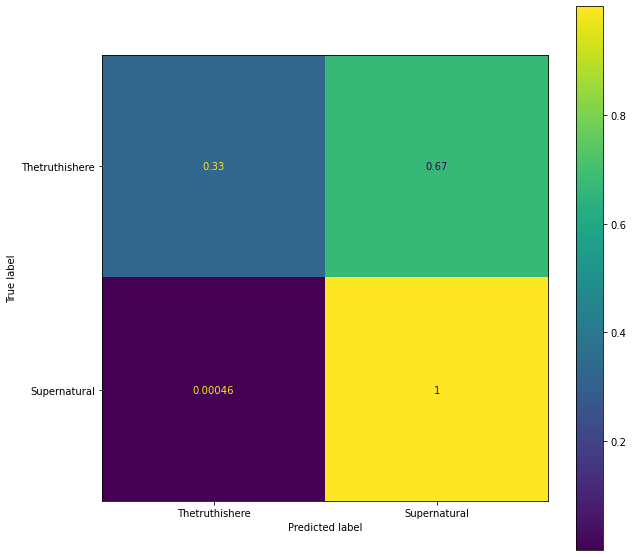

In [31]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('dtree', DecisionTreeClassifier())])
param = [
    {
        'tfidfvectorizer__max_features': [500, 1000],
        'tfidfvectorizer__ngram_range': [(1, 2)],
        'dtree__max_depth':[3,5,7],
        'dtree__min_samples_leaf':[3,5,7], 
        'dtree__ccp_alpha':[.1, 1, 10]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

---

---

<br><br>

### MODEL: CountVectorizer / BaggingClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [100, 500, 1000]<br>'countvectorizer__ngram_range': [(1, 2)]
| Classifier | BaggingClassifier | 'btree__n_estimators':[50, 100, 500] |

*** TEST set ***
Score : 0.9323952278984399
                precision    recall  f1-score   support

  Supernatural       0.90      0.90      0.90      1117
Thetruthishere       0.95      0.95      0.95      2152

      accuracy                           0.93      3269
     macro avg       0.92      0.92      0.92      3269
  weighted avg       0.93      0.93      0.93      3269



Best Params : {'btree__n_estimators': 500, 'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2)}


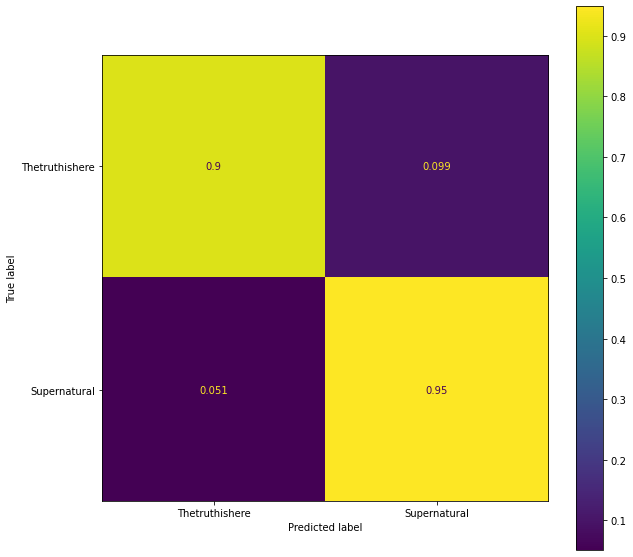

In [32]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('btree', BaggingClassifier())])
param = [
    {
        'countvectorizer__max_features': [500, 1000],
        'countvectorizer__ngram_range': [(1, 2)],
        'btree__n_estimators':[50, 100, 500],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### MODEL: TfidfVectorizer / BaggingClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'tfidfvectorizer__max_features': [100, 500, 1000]<br>'tfidfvectorizer__ngram_range': [(1, 2)]
| Classifier | BaggingClassifier | 'btree__n_estimators':[50, 100, 500] |

*** TEST set ***
Score : 0.9339247476292444
                precision    recall  f1-score   support

  Supernatural       0.92      0.88      0.90      1117
Thetruthishere       0.94      0.96      0.95      2152

      accuracy                           0.93      3269
     macro avg       0.93      0.92      0.93      3269
  weighted avg       0.93      0.93      0.93      3269



Best Params : {'btree__n_estimators': 500, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2)}


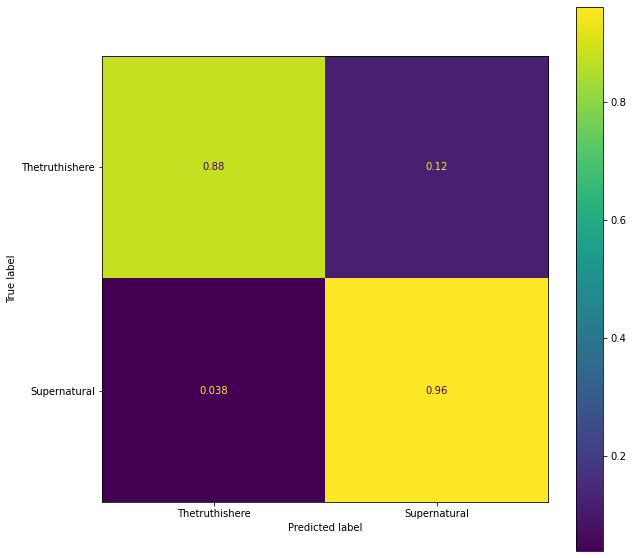

In [4]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('btree', BaggingClassifier())])
param = [
    {
        'tfidfvectorizer__max_features': [500, 1000],
        'tfidfvectorizer__ngram_range': [(1, 2)],
        'btree__n_estimators':[50, 100, 500],
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

---

---

<br><br>

### MODEL: CountVectorizer / RandomForestClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'countvectorizer__max_features': [100, 500, 1000]<br>'countvectorizer__ngram_range': [(1, 2)]
| Classifier | RandomForestClassifier | 'dtree__max_depth':[3,5,7]<br>'dtree__min_samples_leaf':[3,5,7]<br>'dtree__ccp_alpha':[0.1, 1, 10] |

*** TEST set ***
Score : 0.6583052921382686
                precision    recall  f1-score   support

  Supernatural       0.00      0.00      0.00      1117
Thetruthishere       0.66      1.00      0.79      2152

      accuracy                           0.66      3269
     macro avg       0.33      0.50      0.40      3269
  weighted avg       0.43      0.66      0.52      3269



Best Params : {'countvectorizer__max_features': 500, 'countvectorizer__ngram_range': (1, 2), 'randforest__ccp_alpha': 0.1, 'randforest__max_depth': 3, 'randforest__min_samples_leaf': 3}


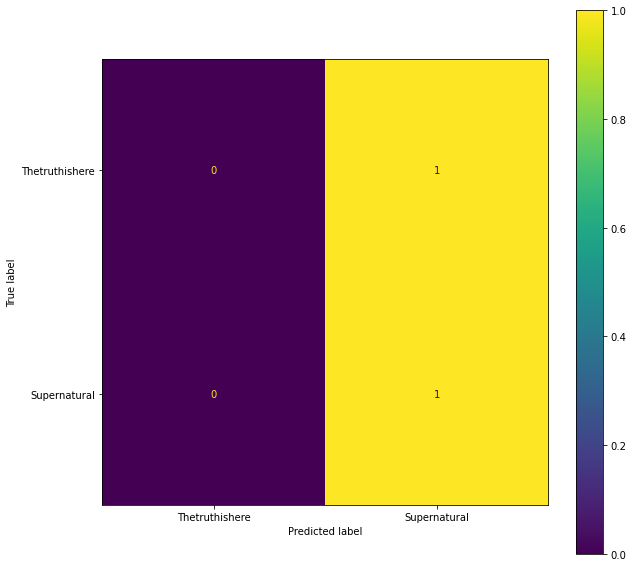

In [5]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('randforest', RandomForestClassifier())])
param = [
    {
        'countvectorizer__max_features': [500, 1000],
        'countvectorizer__ngram_range': [(1, 2)],
        'randforest__max_depth':[3,5,7],
        'randforest__min_samples_leaf':[3,5,7], 
        'randforest__ccp_alpha':[.1, 1, 10]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### MODEL: TfidfVectorizer / RandomForestClassifier

| Step | Name | Paramaters |
| ----------- | ----------- | ----------- |
| Vectorizer | CountVectorizer | 'tfidfvectorizer__max_features': [100, 500, 1000]<br>'tfidfvectorizer__ngram_range': [(1, 2)]
| Classifier | RandomForestClassifier | 'dtree__max_depth':[3,5,7]<br>'dtree__min_samples_leaf':[3,5,7]<br>'dtree__ccp_alpha':[0.1, 1, 10] |

*** TEST set ***
Score : 0.6583052921382686
                precision    recall  f1-score   support

  Supernatural       0.00      0.00      0.00      1117
Thetruthishere       0.66      1.00      0.79      2152

      accuracy                           0.66      3269
     macro avg       0.33      0.50      0.40      3269
  weighted avg       0.43      0.66      0.52      3269



Best Params : {'randforest__ccp_alpha': 0.1, 'randforest__max_depth': 3, 'randforest__min_samples_leaf': 3, 'tfidfvectorizer__max_features': 500, 'tfidfvectorizer__ngram_range': (1, 2)}


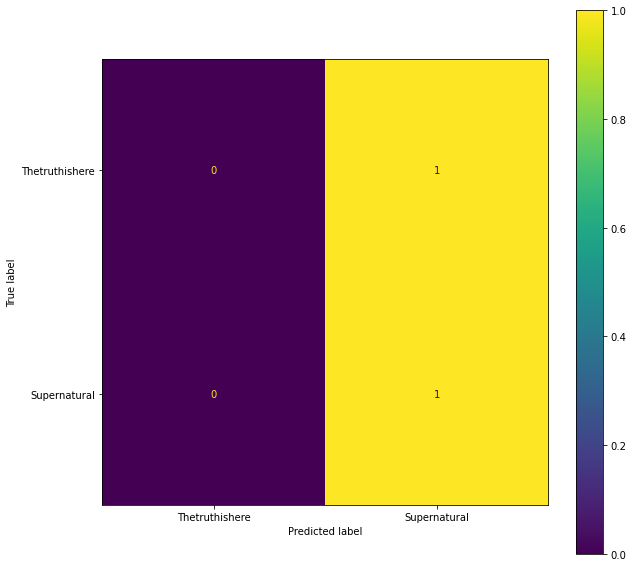

In [6]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()), ('randforest', RandomForestClassifier())])
param = [
    {
        'tfidfvectorizer__max_features': [500, 1000],
        'tfidfvectorizer__ngram_range': [(1, 2)],
        'randforest__max_depth':[3,5,7],
        'randforest__min_samples_leaf':[3,5,7], 
        'randforest__ccp_alpha':[.1, 1, 10]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)